In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df = pd.read_csv('C:\\Users\\Джойчик\\Desktop\\travel_bookings2024.csv', encoding='windows-1251', sep=',')
df["date"] = pd.to_datetime(df["date"])

In [3]:
df.head()

,booking_id,user_id,region_destination,date,bookings,total_amount,region_origin,booking_type,checkin_date,source_channel,user_segment,cancellation_status,checkout_date
0,1001,U0762,Tokyo,2024-12-05,7,193622.218824,Kazan,hotel,2024-12-07,app,premium,0,2024-12-11
1,1002,U0190,New York,2024-04-03,4,133276.059099,Paris,flight,2024-04-27,website,business,0,2024-04-30
2,1003,U0711,Bangkok,2024-07-26,3,81472.709403,Kazan,flight,2024-08-05,app,premium,0,2024-08-06
3,1004,U1508,New York,2024-12-22,3,229810.260086,Moscow,hotel,2025-01-16,partner,premium,0,2025-01-20
4,1005,U1757,New York,2024-08-23,7,259046.534108,St Petersburg,flight,2024-09-21,website,premium,0,2024-09-27


In [4]:
df["cohort_month"] = df.groupby("user_id")["date"].transform("min").dt.to_period("M")
df["booking_month"] = df["date"].dt.to_period("M")

In [5]:
# Считаем уникальных клиентов по когортам и месяцам брони
cohorts = df.groupby(["cohort_month", "booking_month"]).agg({"user_id": "nunique"}).reset_index()  # Число уникальных клиентов
cohort_sizes = cohorts[cohorts["cohort_month"] == cohorts["booking_month"]][["cohort_month", "user_id"]]  # Размер когорты в первый месяц
cohort_sizes.columns = ["cohort_month", "cohort_size"]  # Переименовываем для слияния

In [6]:
cohorts = cohorts.merge(cohort_sizes, on="cohort_month", how="left")

cohorts["retention"] = cohorts["user_id"] / cohorts["cohort_size"]

In [7]:
# Создаём таблицу для тепловой карты
cohort_pivot = cohorts.pivot(index="cohort_month", columns="booking_month", values="retention")
print(cohort_pivot)

booking_month  2024-01   2024-02   2024-03   2024-04   2024-05   2024-06  \
cohort_month                                                               
2024-01            1.0  0.148479  0.291592  0.386404  0.357782  0.386404   
2024-02            NaN  1.000000  0.298893  0.317343  0.369004  0.376384   
2024-03            NaN       NaN  1.000000  0.386293  0.317757  0.448598   
2024-04            NaN       NaN       NaN  1.000000  0.351171  0.364548   
2024-05            NaN       NaN       NaN       NaN  1.000000  0.415789   
2024-06            NaN       NaN       NaN       NaN       NaN  1.000000   
2024-07            NaN       NaN       NaN       NaN       NaN       NaN   
2024-08            NaN       NaN       NaN       NaN       NaN       NaN   
2024-09            NaN       NaN       NaN       NaN       NaN       NaN   
2024-10            NaN       NaN       NaN       NaN       NaN       NaN   
2024-11            NaN       NaN       NaN       NaN       NaN       NaN   
2024-12     

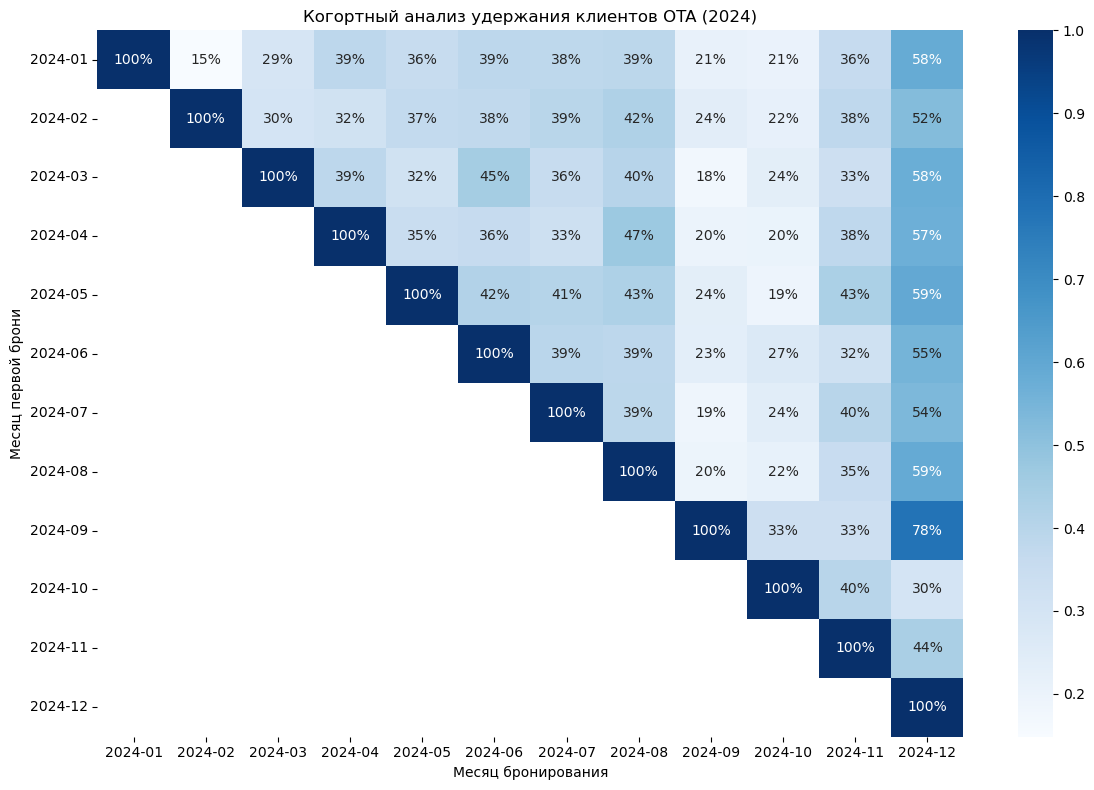

In [8]:
# Создаём тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt=".0%", cmap="Blues", cbar=True)
plt.title("Когортный анализ удержания клиентов OTA (2024)")
plt.xlabel("Месяц бронирования")
plt.ylabel("Месяц первой брони")
plt.tight_layout()
plt.show()

## Ключевые выводы
- **Декабрь (Retention до 77.8%):**  
  - **Наблюдение:** Пик возвращений для всех когорт — новогодний спрос.  
  - **Рекомендация:** Удерживать клиентов акциями в ноябре.

- **Июнь-август (Retention 38–47%):**  
  - **Наблюдение:** Летний всплеск, особенно для мартовских и апрельских когорт.  
  - **Рекомендация:** Предлагать летние туры в мае.

- **Февраль (Retention 14–30%):**  
  - **Наблюдение:** Низкое удержание — спящие клиенты уходят.  
  - **Рекомендация:** Скидки для возвращения.

- **Сентябрь (Retention 17–23%):**  
  - **Наблюдение:** Спад после лета.  
  - **Рекомендация:** Напоминания перед декабрём для "111" из RFM.

## Связь с сезонностью и RFM
- **Декабрьский пик (6,552 брони):** Подтверждает высокий Retention — VIP ("333") возвращаются.  
- **Низкий февраль (1,436 брони):** "111" уходят, нужно активировать